# SAGE

### Overview
A conversational AI agent designed to help users improve their knowledge through interactive discussions and feedback with a focus on data references provided
The agent facilitates group discussions where multiple users can practice and share their knowledge for specific use cases while receiving expert guidance on best practices.

### Motivation
Creating effective prompts for AI systems is a complex challenge that requires both theoretical knowledge and practical experience.
Through collaborative learning and structured practice, users can develop their prompt engineering skills more effectively than working in isolation.
SAGE helps bridge the gap between theoretical understanding and practical application,
allowing users to iteratively refine their prompts based on each specific technique and final goal.

### Key Components
#### Core Features
- Multi-user support with distinct user personas
- Interactive prompt creation exercises
- Real-time feedback based on prompt engineering best practices
- Reference-based learning using markdown documentation that retrives information with Rag System

#### Technical Architecture
- LangGraph for conversation flow management
- Ollma LLM integration for response generation
- Memory-based state management
- Checkpoint saving for conversation continuity

#### Learning Flow
1. Agent introduces the Host of discussion
2. Presents a specific topic
3. Users take turns creating and discussing
4. Agent provides analysis and constructive feedback
5. Session can be continued or concluded with a summary

#### Application Domains (Use Case Shown - Prompt Engineering)
- Training sessions for prompt engineering
- Collaborative prompt development
- Learning prompt engineering best practices
- Improving chatbot and AI system prompts

### Acknowledgment
This implementation is inspired by and utilizes techniques from the comprehensive prompt engineering collection maintained by [NirDiamant](https://github.com/NirDiamant/Prompt_Engineering), specifically focusing on the Role Prompting methodology for creating an effective learning environment.

## Environment : Installs

### Install dependencies
#### Installs required Python packages including:
 - Environment management (python-dotenv)
 - LLM integrations (groq, langchain)
 - Graph processing (langgraph)
 - Vector stores (pinecone, chroma)
 - NLP tools (spacy)


In [ ]:
!pip install python-dotenv==1.0.1
!pip install groq==0.4.2  # For Groq API interactions
!pip install pydantic==2.9.2
!pip install spacy==3.8.2
!pip install langgraph==0.2.48
!pip install langgraph-checkpoint-sqlite==2.0.1
!pip install langchain-core==0.3.18
!pip install langchain-groq==0.2.1

!pip install langchain==0.3.7
!pip install langchain_ollama==0.2.0
!pip install langchain_pinecone==0.2.0
!pip install pinecone-notebooks==0.1.0

!pip install langchain-community==0.3.7
!pip install langchain-chroma==0.1.4

In [ ]:
!apt-get install -y pciutils
!curl https://ollama.ai/install.sh | sh

### 1. Configurations

In [3]:
NEW_LINE = "\n"
GROQ_LLM_INFERENCE = "llama-3.2-3b-preview"
OLLAMA_LLM_INFERENCE = "llama3.2"
OLLAMA_HOST = 'http://0.0.0.0:11434'
LLM_EMBBEDDINGS = "nomic-embed-text"

SPACEY_MODEL = "en_core_web_sm"

LOCAL_ARCHIVE_PATH = "./"
LOCAL_DEFAULT_BOOK = "3300-0.txt"
WEB_DEFAULT_BOOK = "https://www.gutenberg.org/files/3300/3300-0.txt"

CHROMA_STORE = "wealth_of_nations"

INDEX_NAME = "wealthofnations"

IS_LOCAL_ENVIRONMENT = True

### Import libraries

In [4]:
# Vectorstore
import os
import json
import time
import random
import threading
import subprocess

from pathlib import Path
from operator import add
from dotenv import load_dotenv

from langchain_groq import ChatGroq
from langchain_ollama import OllamaEmbeddings, ChatOllama

load_dotenv()

## Embbeddings databases
from langchain_pinecone import PineconeVectorStore
from langchain_chroma import Chroma


## Agent dependencies
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage , AIMessage
from langgraph.graph import add_messages,  StateGraph, START, END
from pydantic import BaseModel
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver

## NER
import spacy

## RAG dependencies:
from langchain_community.document_loaders import (
    DirectoryLoader,
    TextLoader,
)
from langchain.text_splitter import RecursiveCharacterTextSplitter


In [5]:
def ollama():
    os.environ['OLLAMA_HOST'] = OLLAMA_HOST
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "pull", LLM_EMBBEDDINGS])
    subprocess.Popen(["ollama", "pull", OLLAMA_LLM_INFERENCE])
    subprocess.Popen(["ollama", "serve"])

ollama_thread = threading.Thread(target=ollama)
ollama_thread.start()

In [6]:

## Colab custom logic

if not IS_LOCAL_ENVIRONMENT:
  from google.colab import userdata

  os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
  os.environ["PINECONE_API_KEY"] = userdata.get('PINECONE_API_KEY')


In [7]:
##
## PROGRAM LOGIC
##
def build_llm():
  if IS_LOCAL_ENVIRONMENT:
    llm = ChatOllama(model=OLLAMA_LLM_INFERENCE)
  else:
    llm = ChatGroq(model=GROQ_LLM_INFERENCE)
  return llm

llm = build_llm()
nlp = spacy.load(SPACEY_MODEL)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


### 2. Vector Store Setup

In [8]:
## vectorstore
def build_vector_store():
  if not IS_LOCAL_ENVIRONMENT:
    return PineconeVectorStore(index_name=INDEX_NAME, embedding=embeddings)
  else:
    return Chroma(
        embedding_function=embeddings,
        persist_directory=f"{LOCAL_ARCHIVE_PATH}{CHROMA_STORE}"
      )

embeddings = OllamaEmbeddings(model=LLM_EMBBEDDINGS)
embeddings.base_url = os.getenv("OLLAMA_HOST")

vectorstore = build_vector_store()

In [9]:
## Embeddings
from langchain_text_splitters import MarkdownHeaderTextSplitter

def embbed_paragraphs(db):
    sample_docs = DirectoryLoader(
            "./",
            glob="**/*.txt",
            loader_cls=TextLoader,
            show_progress=True,
        ).load()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=50,
        length_function=len,
    )
    documents = text_splitter.split_documents(sample_docs)

    if not IS_LOCAL_ENVIRONMENT:
      # Use Pinecone
      db.from_documents(documents, embedding=embeddings, index_name="wealthofnations")
    else:
      # Use Local Chroma
      db.from_documents(documents, embedding=embeddings)

    return documents

In [10]:
## State
class User(BaseModel):
  name: str
  gender: str
  age: int
  likes: list[str]
  dislikes: list[str]

class Host(User):
  sys_msg: str = None
  personality: list[str]

def add_discussions(discussions, new_messages):
  if not new_messages:
    return []
  return discussions + new_messages

class DiscussionState(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages] = []
  topic: str
  users: list[User]
  host: Host
  curr_discussion: Annotated[list[AnyMessage], add_discussions] = []
  discussion_summaries: Annotated[list[str], add] = []
  setEndDiscussion: bool = False
  random_anchor: str
  book_file_path: str = LOCAL_DEFAULT_BOOK

### 4. Node Functions

Source Material Processing

ingest_source_material: Downloads and stores source material

preprocess_source_material: Performs NER and embeddings

prepare_topic: Selects discussion topics from processed material

#### Discussion Flow

introduce: Host Initiates the session

ask_question: Generates discussion questions
human_discuss: Handles user interactions

agent_interpretations: Analyzes discussion and provides AI feedback

summarize_discussion: Creates discussion summaries

In [11]:
## LangGraph States
def introduce(state):
  host = state['host']
  topic = state['topic']
  users = state['users']

  sys_msg = f"""
  You are a meeting host leading a meeting.

  You will be leading a group of {len(users)} members.

  Your job is to ask a quesetion about the to the users to discuss.

  The following is your information, do not break your character.
  name: {host.name}
  gender: {host.gender}
  age: {host.age}
  personality: {host.personality}


  The following are the information of the club users:
  {NEW_LINE.join([f"{user.name} ({user.gender}, {user.age}" for user in users])}

  The topic that will be discussed is {topic}
  """

  if state.get('guide'):
    sys_msg += f"\n Follow this guide: \n{state.get('guide')}"

  host.sys_msg = sys_msg

  narrator_msg = f"""
  Club members just arrived!
  Before we dive in, please greet the members, introduce yourself, and give brief introductions of the members.
  """
  response = llm.invoke([
    SystemMessage(content=sys_msg),
    HumanMessage(content=narrator_msg, name="narrator")
  ])
  response.name = host.name
  response.content = f"{host.name}: {response.content}"
  response.pretty_print()
  return {
    'message': [response],
    'host': host,
  }

def ingest_source_material(state):
  """
  Downloads source material from the Gutenberg project
  """
  import requests
  response = requests.get(WEB_DEFAULT_BOOK)

  source_file_path = Path(f"{LOCAL_ARCHIVE_PATH}{LOCAL_DEFAULT_BOOK}")
  with open(source_file_path, "w") as source_file:
    source_file.write(response.text)

  return state

def extract_entities(file_path):
    # Read the text file
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    # Process the text with spaCy
    nlp.max_length = len(text)
    doc = nlp(text)

    # Extract entities and organize them by type
    entities = {}
    for ent in doc.ents:
        if ent.label_ not in entities:
            entities[ent.label_] = set()
        entities[ent.label_].add(ent.text)

    for key, value in entities.items():
        entities[key] = list(value)

    return entities


def preprocess_source_material(state):
  """
  Performs NER against source material
  """
  embbed_paragraphs(vectorstore)

  entities_file_path = Path(f"{LOCAL_ARCHIVE_PATH}entities_{LOCAL_DEFAULT_BOOK}")

  found_entities = extract_entities(f"{LOCAL_ARCHIVE_PATH}{LOCAL_DEFAULT_BOOK}")
  json_entities = json.dumps(found_entities)

  with open(entities_file_path, "w") as output:
      output.write(json_entities)

  return state

def prepare_topic(state):
  entities_file_path = Path(f"{LOCAL_ARCHIVE_PATH}entities_{LOCAL_DEFAULT_BOOK}")

  with open(entities_file_path, "r") as entities_file:
    entities = json.loads(entities_file.read())

  persons = entities.get("PERSON")
  size = len(persons)

  state['random_anchor'] = persons[random.randint(1, size)]
  return state

def should_download_source_material(state):
  source_file_path = Path(f"{LOCAL_ARCHIVE_PATH}{LOCAL_DEFAULT_BOOK}")

  if(not source_file_path.exists() or not source_file_path.is_file()):
    return "web_download"

  entities_file_path = Path(f"{LOCAL_ARCHIVE_PATH}entities_{LOCAL_DEFAULT_BOOK}")

  if(not entities_file_path.exists() or not entities_file_path.is_file()):
    return "embeddings_ner"

  return "prepare_topic"

def should_prepare_source_material(state):
  entities_file_path = Path(f"{LOCAL_ARCHIVE_PATH}entities_{LOCAL_DEFAULT_BOOK}")

  if(not entities_file_path.exists() or not entities_file_path.is_file()):
    return "embeddings_ner"

  return "prepare_topic"

def ask_question(state):
  # 1. find any interesting topic from retriever

  retriever = vectorstore.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k": 1, "score_threshold": 0.5},
  )

  if not IS_LOCAL_ENVIRONMENT:
    # Use Pinecone
    results = retriever.invoke(state['random_anchor'], filter={"source": "wealthofnations"})
  else:
    # Use Local Chroma
    results = retriever.invoke(state['random_anchor'])


  # referenced_document = list(results)[0].page_content
  referenced_document = "test"

  # 2. generate interesting question from the topic
  host = state['host']

  narrator_msg = f"""
  Present an interesting and insightful question from the topic from the following interesting fact(s):
  {referenced_document}

  Remember that you are the host, do not break the character.
  """
  response = llm.invoke([
    SystemMessage(content=host.sys_msg),
    SystemMessage(content="Your job is to ask a quesetion about the topic to the users for dicsussion."),
    HumanMessage(content=narrator_msg, name="narrator")
  ])
  response.name = host.name
  response.content = f"{host.name}: {response.content}"
  response.pretty_print()
  return {
    'message': [response],
    'curr_discussion': [response],
    "setEndDiscussion": False
  }

def human_discuss(state):
  # Discussions among users\
  end_discussion = False
  user_messages = []
  user_options = {str(i+1): user.name for i, user in enumerate(state['users'])}
  participating_users = set()  # Track who has participated
  while True:
    print("===" * 10 + "USER INPUT" + "===" * 10)
    user_ind = input(f"{user_options}\nWho are you (type number to select user OR 'q' to quit): ")

    if user_ind.isdigit() and int(user_ind) in range(1, len(state['users'])+1):
      user = state['users'][int(user_ind) - 1]
      participating_users.add(user.name)  # Track this user's participation
      user_input = input(f"{user.name}: ")
      user_messages.append(HumanMessage(content=f"{user.name}: {user_input}", user_id=user.name))
      break
    elif user_ind == 'q':
      end_discussion = True
      # Add empty messages for all silent users
      silent_users = [user for user in state['users'] if user.name not in participating_users]
      for silent_user in silent_users:
        user_messages.append(HumanMessage(content=f"{silent_user.name}: '......'", user_id=silent_user.name))
      break
    else:
      print("Invalid input. Please enter a number between 1 and", len(state['users']))

  return {
    "curr_discussion": user_messages,
    "setEndDiscussion": end_discussion
  }

def summarize_discussion(state):
  curr_discussion = state['curr_discussion']
  sys_msg = """
  You are a summarizer of a discussion. Your job is to summarize the following conversations
  """
  response = llm.invoke(
    [SystemMessage(content=sys_msg)] + curr_discussion
  )
  response.pretty_print()
  return {
    'discussion_summaries': [response.content],
  }

def agent_interjection(state):
  curr_discussion = state['curr_discussion']
  host = state['host']
  topic = state['topic']
  users = state['users']

  sys_msg = f"""
  You are {host.name}, a club host discussing {topic}. Your traits: {', '.join(host.personality)}

  You will always respond as host "{host.name}: message"

  Club members present:
  {', '.join([f"{user.name} (interests: {', '.join(user.likes)})" for user in users])}

  only address the members present in the discussion.

  When analyzing the discussion, pay extra attention to:
  1. Who said what - track each member's specific contributions accurately
  2. The depth of each response - look for opportunities to expand shallow comments
  3. The engagement level of each participant
  4. Accuracy in referencing previous comments
  5. If members are silent, which is indicated by '......'.

  When intervening:
  - Always acknowledge the specific points made by each member
  - Build on their existing comments and dont assume there responses other than what they said.
  - Ask follow-up questions that directly relate to their statements
  - Maintain conversation flow by connecting members' comments to each other
  - If members are silent, Make first engage them to say hi and then use their interests to draw them in

  IMPORTANT: Respond ONLY with a valid JSON object in the following format:
  {{
      "thought_process": "Your step-by-step analysis for intervention",
      "should_intervene": boolean,
      "message": "Your intervention message if should_intervene is true and based on your thought process"
  }}
  """

  narrator_msg = f"""
  Current discussion (in chronological order):
  {NEW_LINE.join([f"- {msg.content}" for msg in curr_discussion])}

  Analyze the above discussion and decide if you should intervene to help members engage with {topic}.
  """

  response = llm.invoke(
    [SystemMessage(content=sys_msg)] + [HumanMessage(content=narrator_msg, name="narrator")]
  )

  # Parse the response and act accordingly
  try:
    import json
    response_data = json.loads(response.content)

    #print("Response data: ================")
    #print(response_data)

    if response_data["should_intervene"]:
      ai_response = AIMessage(content=response_data["message"])
      print(ai_response.pretty_print())
      return {
        'messages': [ai_response],
        'curr_discussion': [ai_response]
      }
  except json.JSONDecodeError as e:
    return {
        'messages': state['messages'],
        'curr_discussion': state['curr_discussion']
      }

def ask_to_continue(state) -> Literal['ask_question', END]:
  print("---" * 25)
  user_input = input("\nContinue with another question? y/n: ")
  if user_input.lower() == 'y':
    return "ask_question"
  else:
   return END

def route_discussion(state) -> Literal['agent_interjection', 'summarize_discussion']:
    # print("Came to route discussion")
    # Check if last message indicates quitting
    if state['setEndDiscussion'] : #state['curr_discussion'] and state['curr_discussion'][-2].content.split(":")[-1].strip().lower() == 'q':
        print("Went to summarize discussion")
        state['setEndDiscussion'] = False
        return 'summarize_discussion'
    return 'agent_interjection'



### 5. Graph Setup

In [12]:
builder = StateGraph(DiscussionState)

builder.add_node(introduce)
#builder.add_node('web_download', web_to_local_node)
builder.add_node('web_download', ingest_source_material)
builder.add_node('embeddings_ner', preprocess_source_material)

builder.add_node(prepare_topic)
builder.add_node(ask_question)
builder.add_node(human_discuss)
builder.add_node(agent_interjection)
builder.add_node(summarize_discussion)

builder.add_edge(START, 'introduce')
builder.add_conditional_edges('introduce', should_download_source_material, ['web_download', 'embeddings_ner', 'prepare_topic'])
builder.add_conditional_edges('web_download', should_prepare_source_material, ['embeddings_ner', 'prepare_topic'])
builder.add_edge('embeddings_ner', 'prepare_topic')
builder.add_edge('prepare_topic', 'ask_question')

builder.add_edge('ask_question', 'human_discuss')
builder.add_edge('agent_interjection', 'human_discuss')
builder.add_conditional_edges('human_discuss',route_discussion)
builder.add_conditional_edges('summarize_discussion', ask_to_continue)

memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

### 6. Graph Visualization

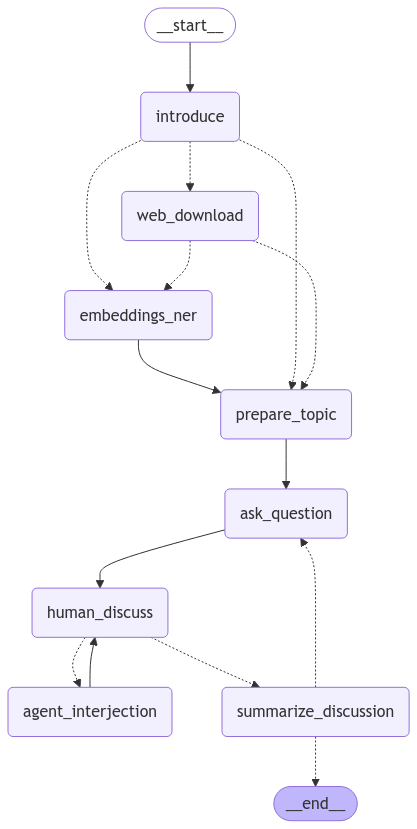

In [13]:
from IPython.display import display, Image

display(Image(agent.get_graph().draw_mermaid_png()))

In [17]:
users = [
    User(name="Alice", gender="female", age=30, likes=["Mathemathics", "Japanese"], dislikes=["Biology"]),
    User(name="Bob", gender="male", age=25, likes=["Science Fiction", "Fantasy"], dislikes=["Health Sciences"]),
    User(name="Charlie", gender="female", age=28, likes=["Humanities", "Classic Literature"], dislikes=["Economics"])
]
test_state = {
  'topic': "prompt engineering labor value",
  'users':users,
  'host': Host(name="Vander", gender="male", age=40, likes=["Book Club", "Knowledge"], dislikes=["Ignorance"], personality=["Enthusiastic", "Humorous", "Terse"]),
}
config = {
  'configurable': {'thread_id': 2}
}
setEndDiscussion = False

response = agent.invoke(test_state, config=config)

================================== Ai Message ==================================
Name: Vander

Vander: (big smile) Ah, great to see everyone here! Welcome to our meeting today. I'm Vander, your host for today's discussion. (extends hand for a handshake or a friendly greeting)

Before we dive into the topic at hand, let me introduce myself and my fellow club members. We have some fantastic minds gathered in this room today.

First up, we have Alice. Welcome, Alice! (nods towards Alice) A 30-year-old professional with a passion for data science and machine learning. Her expertise in natural language processing will undoubtedly bring valuable insights to our discussion.

Next, please give a warm welcome to Bob. (turns to Bob) Bob's an 25-year-old rising star in the field of artificial intelligence. His enthusiasm for prompt engineering is contagious, and I'm sure he'll be sharing some exciting ideas with us today.

Last but not least, we have Charlie. (smiles at Charlie) Charlie, a 28-yea